# Characterizing the Hypergraph-of-Entity Representation Model

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [343]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr,
    stringr,
    dplyr,
    xtable
)

basicConfig()
options(warn=-1)
options(scipen=1)
options(xtable.include.rownames=FALSE)

base_dir <- "data/inex_2009_10t_nl/base_model"

## Node degree and hyperedge cardinality distributions

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [14]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "name", "v_degree", "e_degree", "in_v_degree", "out_v_degree",
          "in_e_degree", "out_e_degree", "dir_in_v_degree", "dir_out_v_degree", "dir_in_e_degree", "dir_out_e_degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_cardinality_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-cardinality-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "cardinality", "undirected_cardinality",
          "tail_cardinality", "head_cardinality"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [15]:
node_degree <- load_node_degree_data(file.path(base_dir, "global"))
head(node_degree)

node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
0,entity,Irina Slutskaya,8564,11,8564,8564,11,10,2,0,1,0
1,entity,Central Industrial Security Force,1791,5,1791,1791,5,4,1,0,1,0
2,entity,Mao Asada,1778,9,1778,1778,9,8,2,0,1,0
3,entity,Ranked 3rd,404,3,404,404,3,2,1,0,1,0
4,entity,List of people from Saint Petersburg,3659,4,3659,3657,4,3,5,0,1,0
5,entity,Andrey Markov,755,3,755,755,3,2,1,0,1,0


In [181]:
edge_cardinality <- load_edge_cardinality_data(file.path(base_dir, "global"))
head(edge_cardinality)

edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
0,document,FALSE,853,853,0,0
1,document,FALSE,404,404,0,0
2,document,FALSE,364,364,0,0
3,document,FALSE,755,755,0,0
4,related_to,FALSE,20,20,0,0
5,related_to,FALSE,178,178,0,0


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [182]:
plot_degree_per_type <- function(data, label, name="degree") {
    data <- split(data, data$type)
    data <- lapply(data, function(d) {
      cbind(
          type=d$type[1],
          setNames(as.data.frame(table(d[[name]])), c(name, "freq")))
    })
    data <- do.call(rbind, data)
    data[[name]] <- as.numeric(as.character(data[[name]]))

    ggplot(data, aes_string(x=name, y="freq")) +
        facet_wrap(~type) +
        geom_point(size=0.5) +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

### Node degree distributions

As we can see, the node node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

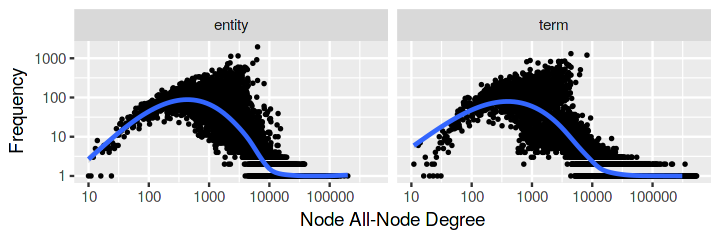

In [319]:
options(repr.plot.width=6, repr.plot.height=2)
plot_degree_per_type(node_degree, "Node All-Node Degree", "v_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/node_all_node_degree.png", width = 6, height = 2, dpi = 300)

However, the hyperedge node degree distribution, slightly approximates a power law.

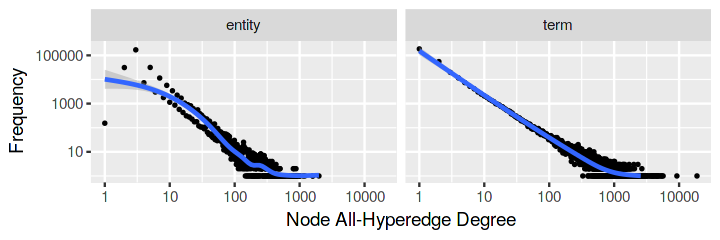

In [320]:
options(repr.plot.width=6, repr.plot.height=2)
plot_degree_per_type(node_degree, "Node All-Hyperedge Degree", "e_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/node_all_hyperedge_degree.pdf", width = 6, height = 2, dpi = 300)

#### Node degree distributions based on directed hyperedges

If we only consider directed hyperedges, the node incoming-node degree does not follow a power law.

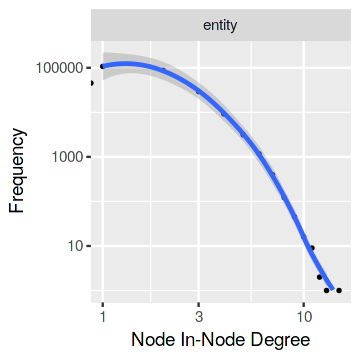

In [321]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Node Degree", "dir_in_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree approximates a power law, although it is more heavy-tailed.

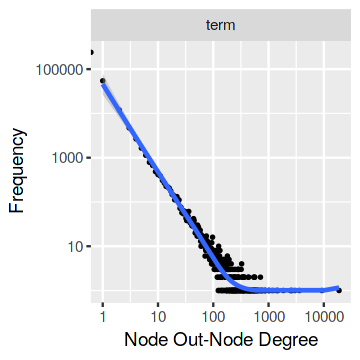

In [322]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Node Degree", "dir_out_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node incoming-hyperedge degree is always one.

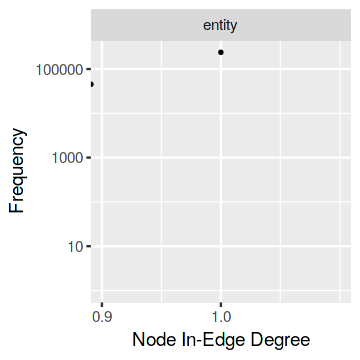

In [323]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Edge Degree", "dir_in_e_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree, approximates a power law, although it is more heavy-tailed.

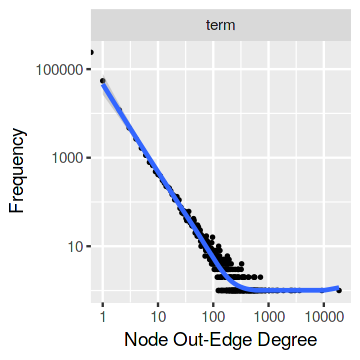

In [324]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Edge Degree", "dir_out_e_degree") +
    stat_smooth(method = "loess")

### Hyperedge cardinality distributions

The hyperedge cardinality distributions do not follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

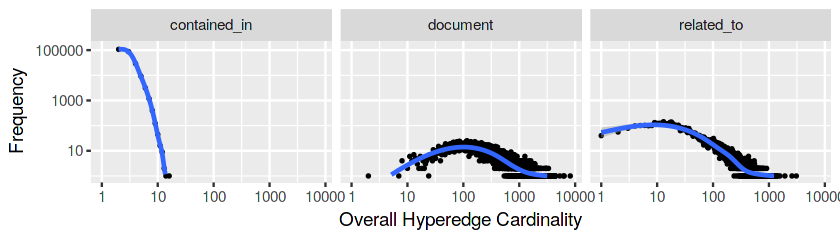

In [325]:
options(repr.plot.width=7, repr.plot.height=2)
plot_degree_per_type(edge_cardinality, "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/hyperedge_overall_cardinality.png", width = 7, height = 2, dpi = 300)

#### Hyperedge cardinality distribution based on directed hyperedges

If we only consider directed hyperedges, the tail cardinality has the following non-power-law distribution.

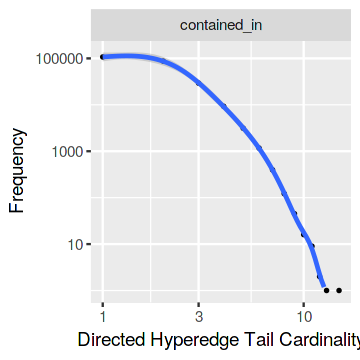

In [327]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Tail Cardinality", "tail_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

For directed hyperedges, the head cardinality is always one.

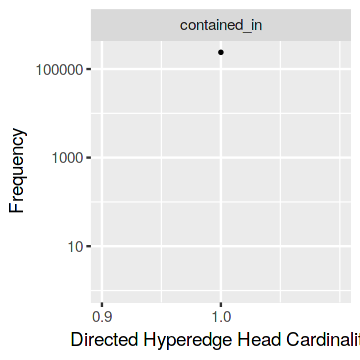

In [328]:
options(repr.plot.width=3, repr.plot.height=3)
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Head Cardinality", "head_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

## Top 10 nodes

### Node incoming-node degree

In [329]:
top_10_terms_by_incoming_node_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_terms_by_incoming_node_degree

node_id,name,in_v_degree
466,also,537951
580,new,522929
533,on,512256
840,first,509026
1106,time,492091
1089,refer,484452
616,see,482742
901,state,478662
1082,link,475903
736,includ,473517


In [330]:
top_10_entities_by_incoming_node_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_entities_by_incoming_node_degree

node_id,name,in_v_degree
1451,United States,199796
294,India,174817
110,Japan,154539
7915,France,146492
3265,2007,136161
9448,World War II,134358
6000,Germany,133949
3275,2006,130566
413,Russia,126066
6538,Italy,124616


### Node incoming-hyperedge degree

In [331]:
top_10_terms_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_terms_by_incoming_hyperedge_degree

node_id,name,in_e_degree
466,also,5384
1089,refer,4700
1082,link,4557
1081,extern,4464
533,on,4419
580,new,4199
840,first,4093
1106,time,4007
616,see,3996
736,includ,3848


In [332]:
top_10_entities_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_entities_by_incoming_hyperedge_degree

node_id,name,in_e_degree
1451,United States,1984
5354,Scientific classification,1596
294,India,1587
110,Japan,1205
5538,Dinosaur,1129
3265,2007,1009
3275,2006,1005
7915,France,984
6000,Germany,922
11537,Canada,917


## Global statistics

In [333]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [361]:
stats <- rbind(
    load_stats_data(file.path(base_dir, "global")),
    data.frame(
        Statistic=c(
            "Term Vertices",
            "Entity Vertices",
            "contained_in Hyperedges",
            "document Hyperedges",
            "related_to Hyperedges"
        ),
        Value=c(
            nrow(node_degree[node_degree$type == "term", ]),
            nrow(node_degree[node_degree$type == "entity", ]),
            nrow(edge_cardinality[edge_cardinality$type == "contained_in", ]),
            nrow(edge_cardinality[edge_cardinality$type == "document", ]),
            nrow(edge_cardinality[edge_cardinality$type == "related_to", ])
        )
    ))
stats
#print(xtable(stats, digits = 10))

Statistic,Value
Vertices,6.072130e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,1.493800e+04
Total Hyperedges,2.531540e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,3.881173e-06
Avg. Degree,8.338227e-01
Min InEdge Degree,1.000000e+00
Max InEdge Degree,5.384000e+03


## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree;
 - Average node incoming edge degree;
 - Average node outgoing edge degree;
 - Average node incoming node degree;
 - Average node outgoing node degree;
- Average hyperedge cardinality;
 - Average cardinality for undirected hyperedges;
 - Average tail cardinality for directed hyperedges;
 - Average head cardinality for directed hyperedges;
- Estimated clustering coefficient;
- Estimated average path length and diameter;
- General mixed hypergraph density;
- Size and space usage;
 - Number of nodes;
 - Number of hyperedges;
 - Number of bytes in disk;
 - Number of bytes in memory.

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [100]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(
                paste("load", type, ifelse(type == "node", "degree", "cardinality"), "data", sep="_"),
                list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [101]:
snapshot_node_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="node")
head(snapshot_node_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
snapshot_001_1,001,1,0,entity,Cochrane Theatre,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,1,entity,Cochrane (disambiguation),123,1,123,123,1,1,0,0,0,0
snapshot_001_1,001,1,2,entity,"Cochrane, Wisconsin",123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,3,entity,"Cochrane, Chile",123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,4,entity,Zefram Cochrane,123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,5,entity,Kuala Lumpur,123,3,123,123,3,2,2,0,1,0


In [102]:
snapshot_edge_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="edge")
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
snapshot_001_1,001,1,0,document,FALSE,123,123,0,0
snapshot_001_1,001,1,1,related_to,FALSE,28,28,0,0
snapshot_001_1,001,1,2,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,3,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,4,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,5,contained_in,TRUE,3,0,2,1


In [106]:
plot_degree_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(!!sym(stat), na.rm=TRUE))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(!!sym(stat)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average node degree

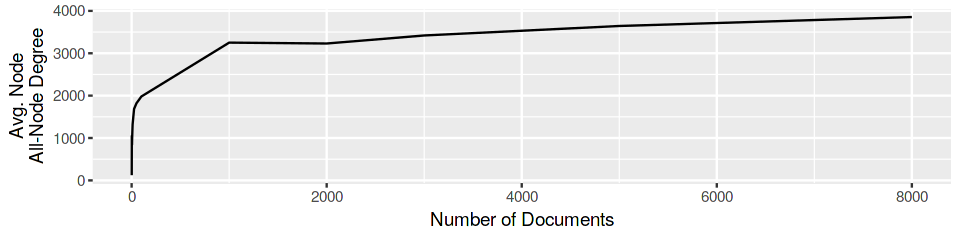

In [370]:
options(repr.plot.width=8, repr.plot.height=2)
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Node Degree", stat = "v_degree")
ggsave(filename = "output/snapshot_average_all_node_degree.png", width = 8, height = 2, dpi = 300)

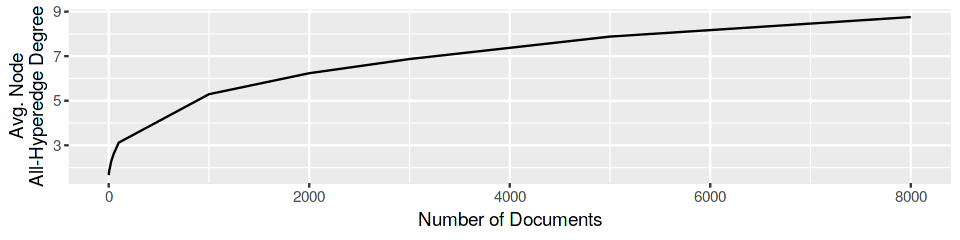

In [371]:
options(repr.plot.width=8, repr.plot.height=2)
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Hyperedge Degree", stat = "e_degree")
ggsave(filename = "output/snapshot_average_all_hyperedge_degree.png", width = 8, height = 2, dpi = 300)

#### Average node degree based on directed hyperedges

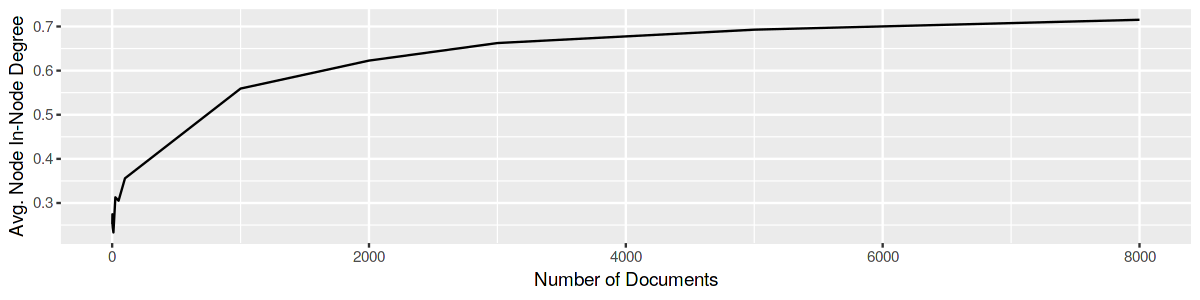

In [231]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Node Degree", stat = "dir_in_v_degree")

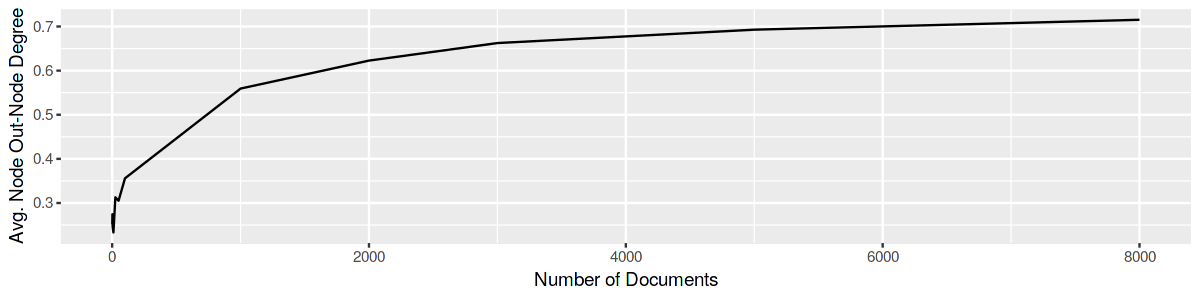

In [232]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Node Degree", stat = "dir_out_v_degree")

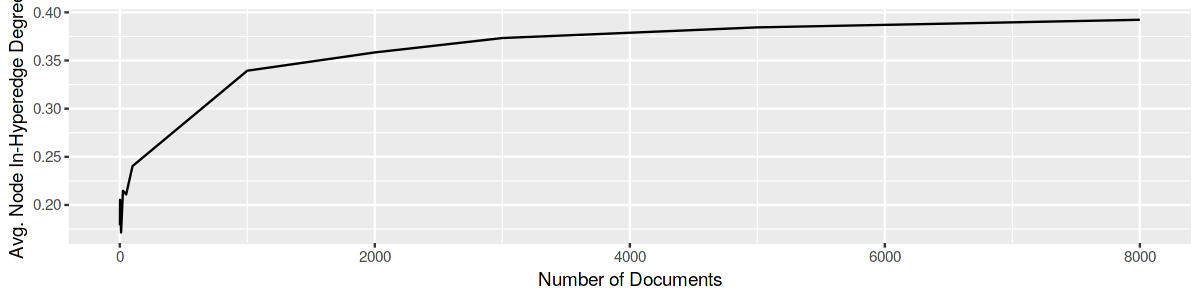

In [258]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Hyperedge Degree", stat = "dir_in_e_degree")

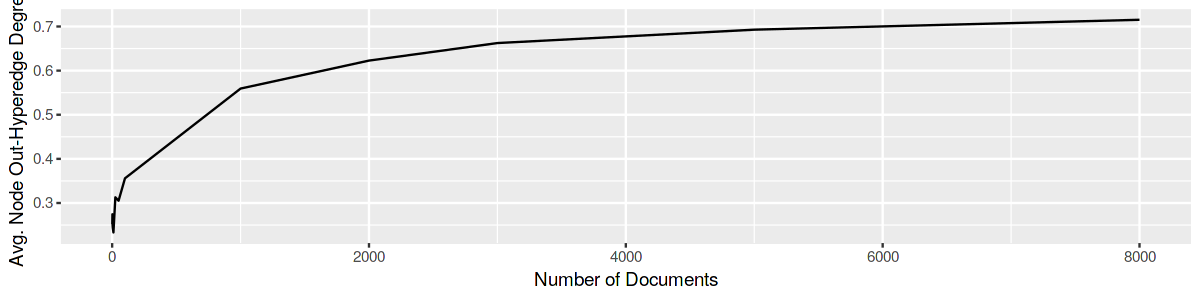

In [256]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Hyperedge Degree", stat = "dir_out_e_degree")

### Average hyperedge cardinality

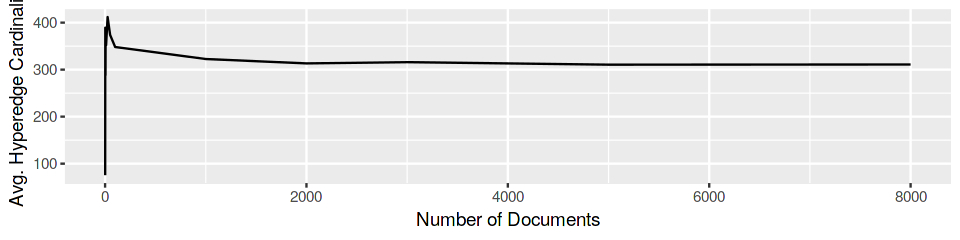

In [373]:
options(repr.plot.width=8, repr.plot.height=2)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Hyperedge Cardinality", stat = "cardinality")
ggsave(filename = "output/snapshot_average_hyperedge_cardinality.png", width = 8, height = 2, dpi = 300)

#### Average directed hyperedge cardinalities

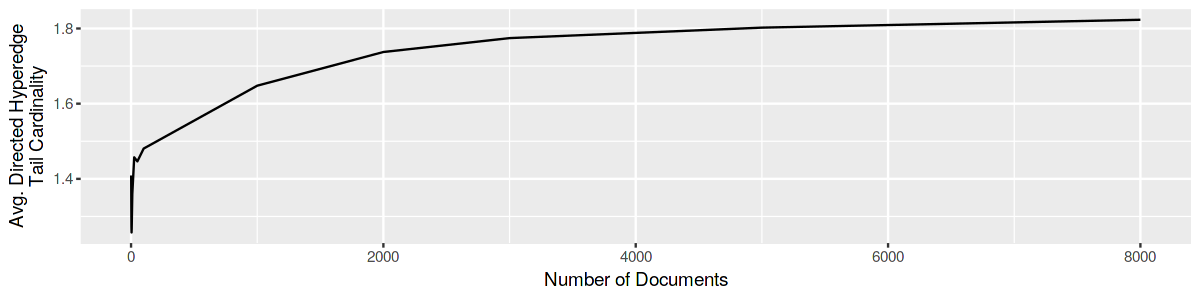

In [239]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed), "Avg. Directed Hyperedge\nTail Cardinality", stat = "tail_cardinality")

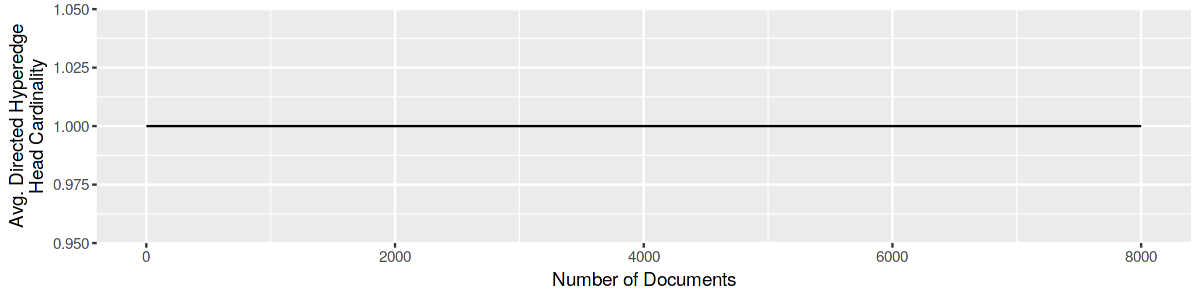

In [240]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed), "Avg. Directed Hyperedge\nHead Cardinality", stat = "head_cardinality")

### Estimated clustering coefficient

In [127]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [128]:
snapshot_stats <- load_snapshots_stats_data(file.path(base_dir, "snapshots"))
head(snapshot_stats)

snapshot_name,snapshot_id,num_docs,statistic,value
snapshot_001_1,001,1,Vertices,123
snapshot_001_1,001,1,Directed Hyperedges,22
snapshot_001_1,001,1,Undirected Hyperedges,2
snapshot_001_1,001,1,Total Hyperedges,24
snapshot_001_1,001,1,Num Sources,0
snapshot_001_1,001,1,Num Sinks,0


In [396]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE) {
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=statistic)) +
            scale_color_discrete("Statistic") +
            theme(
                legend.position=c(0.8, 0.8),
                legend.direction="horizontal")
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

In [130]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,snapshot_name,snapshot_id,num_docs,statistic,value
17,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.5869933
36,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.5592256
55,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.5491855
74,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.5472917
93,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.4984415
112,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.4746736
131,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3865079
150,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.3230005
169,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.2641110
188,snapshot_010_1000,010,1000,Avg. Clustering Coefficient,0.1637668


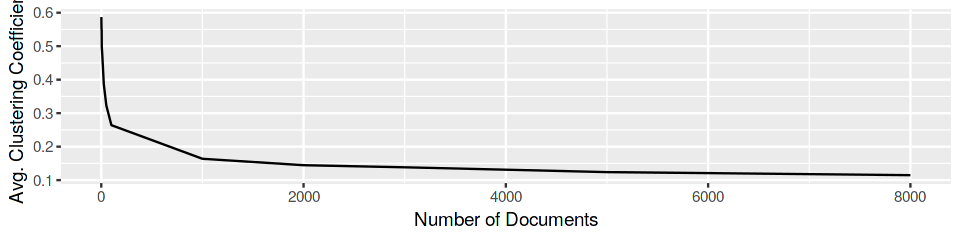

In [374]:
options(repr.plot.width=8, repr.plot.height=2)
plot_statistics_over_time(snapshot_cc, "Avg. Clustering Coefficient")
ggsave(filename = "output/snapshot_avg_clustering_coefficient.png", width = 8, height = 2, dpi = 300)

### Estimated average path length and diameter

In [132]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths

,snapshot_name,snapshot_id,num_docs,statistic,value
18,snapshot_001_1,001,1,Diameter,491.000000
19,snapshot_001_1,001,1,Avg. Path Length,126.066666
37,snapshot_002_2,002,2,Diameter,10.000000
38,snapshot_002_2,002,2,Avg. Path Length,3.766667
56,snapshot_003_3,003,3,Diameter,9.000000
57,snapshot_003_3,003,3,Avg. Path Length,4.066667
75,snapshot_004_4,004,4,Diameter,9.000000
76,snapshot_004_4,004,4,Avg. Path Length,3.700000
94,snapshot_005_5,005,5,Diameter,8.000000
95,snapshot_005_5,005,5,Avg. Path Length,4.200000


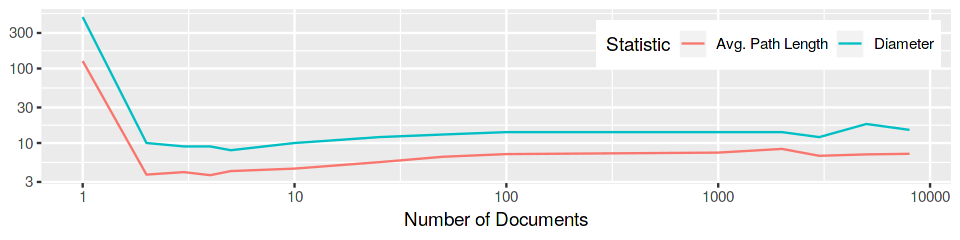

In [397]:
options(repr.plot.width=8, repr.plot.height=2)
plot_statistics_over_time(snapshot_paths, NULL, log_scale = TRUE)
ggsave(filename = "output/snapshot_avg_shortest_path_stats.png", width = 8, height = 2, dpi = 300)

### General mixed hypergraph density

In [134]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
snapshot_density

,snapshot_name,snapshot_id,num_docs,statistic,value
7,snapshot_001_1,001,1,Density,1.374522e-03
26,snapshot_002_2,002,2,Density,1.401240e-04
45,snapshot_003_3,003,3,Density,1.047619e-04
64,snapshot_004_4,004,4,Density,9.483004e-05
83,snapshot_005_5,005,5,Density,6.345873e-05
102,snapshot_006_10,006,10,Density,3.428081e-05
121,snapshot_007_25,007,25,Density,1.582643e-05
140,snapshot_008_50,008,50,Density,1.059882e-05
159,snapshot_009_100,009,100,Density,7.659471e-06
178,snapshot_010_1000,010,1000,Density,4.738997e-06


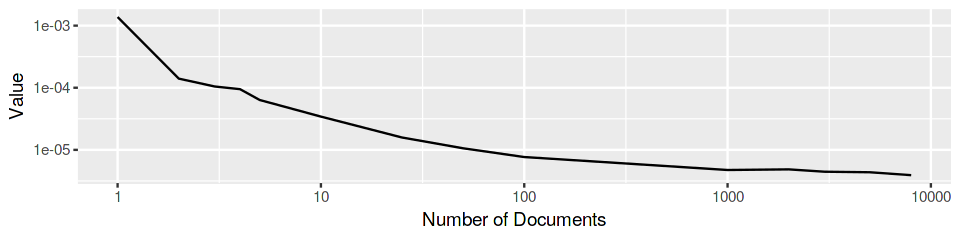

In [398]:
options(repr.plot.width=8, repr.plot.height=2)
plot_statistics_over_time(snapshot_density, "Value", log_scale = TRUE)
ggsave(filename = "output/snapshot_avg_density.png", width = 8, height = 2, dpi = 300)

### Size and space usage

#### Number of nodes and hyperedges

The growth in number of nodes is sublinear in regard to the number of documents.

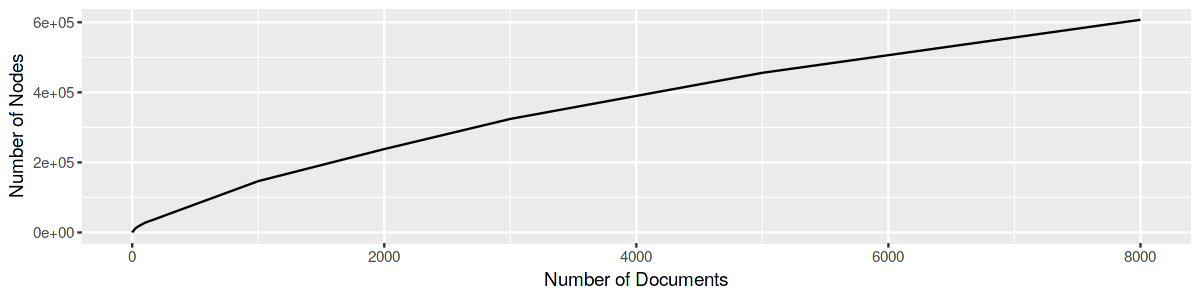

In [213]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_size_over_time(snapshot_node_degree, "Number of Nodes", stat = "node_id")

Similarly, the growth in number of hyperedges is sublinear in regard to the number of documents, although there are significantly less hyperedges than nodes.

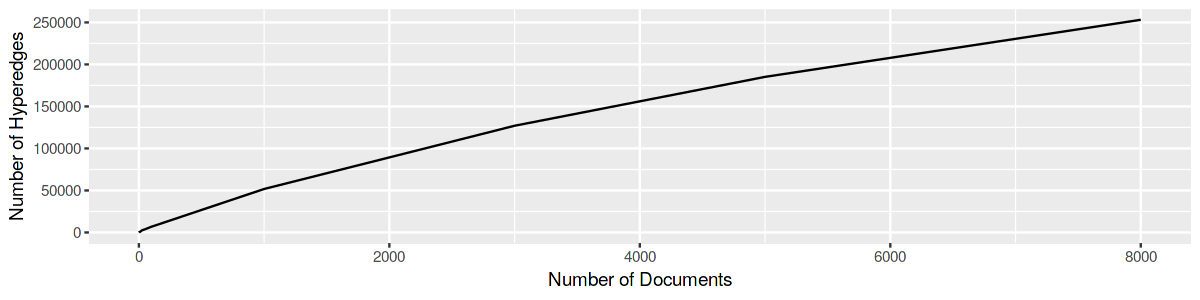

In [212]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges", stat = "edge_id")

#### Number of bytes in disk and memory

In [157]:
load_snapshots_space_usage_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            read.csv(file.path(snapshot_dir, list.files(path = snapshot_dir, pattern = "space-usage-.*\\.csv"))))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [211]:
snapshot_space <- load_snapshots_space_usage_data(file.path(base_dir, "snapshots"))
head(snapshot_space)

snapshot_name,snapshot_id,num_docs,Statistic,Value
snapshot_001_1,001,1,Disk (Bytes),44857
snapshot_001_1,001,1,Memory (Bytes),1089921536
snapshot_002_2,002,2,Disk (Bytes),303211
snapshot_002_2,002,2,Memory (Bytes),1089921536
snapshot_003_3,003,3,Disk (Bytes),384076
snapshot_003_3,003,3,Memory (Bytes),1089921520


In [216]:
plot_space_usage <- function(data, label, stat = "Disk (Bytes)", unit="MB") {
    data <- data %>% filter(Statistic == stat)
    
    stopifnot(unit %in% c("B", "KB", "MB", "GB", "TB"))
    
    if (unit == "B") {
        frac <- 1
    } else if (unit == "KB") {
        frac <- 1024
    } else if (unit == "MB") {
        frac <- 1024^2
    } else if (unit == "GB") {
        frac <- 1024^3
    } else if (unit == "TB") {
        frac <- 1024^4
    }
    
    ggplot(data, aes(x = num_docs, y = Value / frac)) +
        geom_line() +
        scale_y_continuous(label = function(s) paste(s, unit)) +
        xlab("Number of Documents") +
        ylab(label)
}

The growth in disk space is sublinear in regard to the number of documents.

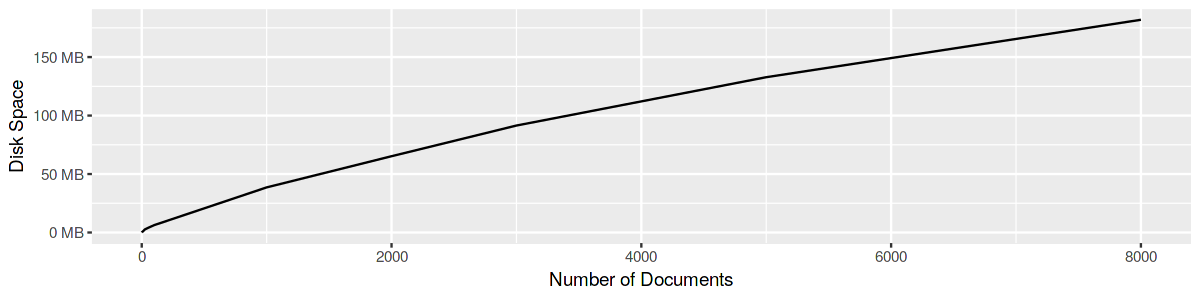

In [217]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_space_usage(snapshot_space, "Disk Space", stat = "Disk (Bytes)")

The growth in memory space is sublinear in regard to the number of documents, presenting a sharper growth for the first 1000 documents.

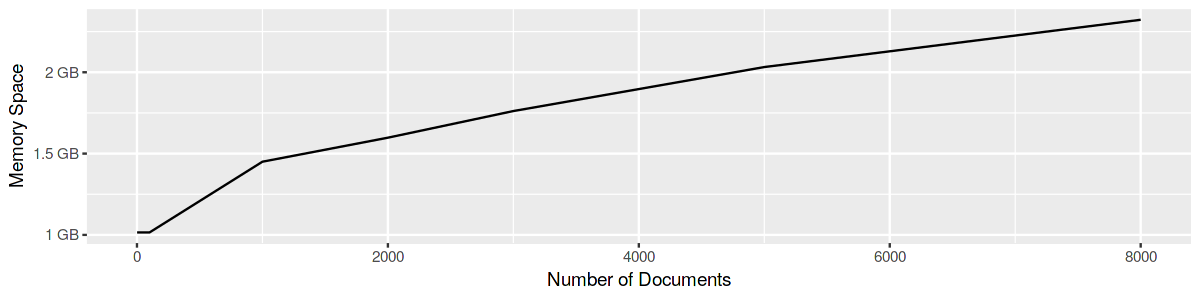

In [218]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_space_usage(snapshot_space, "Memory Space", stat = "Memory (Bytes)", unit = "GB")